# 1. baseline_model

## seed = 43

## 0. 기본경로 설정

In [1]:
import os, torch, numpy as np

BASE_DIR = "./empathy_roberta_baseline"
BEST_DIR = os.path.join(BASE_DIR, "best_model")   # 스샷에서 보인 폴더
print(BEST_DIR)

./empathy_roberta_baseline\best_model


## 1. 모델 로드 + 데이터셋 로드

In [2]:
from datasets import load_from_disk

DATASET_PATH = "./empathy_dataset/hf_tokenized_roberta-base"  # 네가 쓰던 경로로 수정
ds = load_from_disk(DATASET_PATH)

for split in ds.keys():
    ds[split].set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels", "emotion_labels"],
    )

num_emotions = int(torch.max(ds["train"]["emotion_labels"]).item() + 1)
print("splits:", ds.keys())
print("num_emotions:", num_emotions)


splits: dict_keys(['train', 'validation', 'test'])
num_emotions: 32


In [3]:
import torch.nn as nn
from transformers import AutoModel

MODEL_NAME = "roberta-base"   # 학습 때 쓴 것과 동일하게

class EmpathyBaselineMultiTask(nn.Module):
    def __init__(self, model_name: str, num_emotions: int, lambda_emo: float = 0.3):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden = self.encoder.config.hidden_size

        self.dropout = nn.Dropout(0.1)
        self.reg_head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden, 1),
        )
        self.emo_head = nn.Linear(hidden, num_emotions)

        self.loss_reg = nn.MSELoss()
        self.loss_ce = nn.CrossEntropyLoss()
        self.lambda_emo = lambda_emo

    def forward(self,
        input_ids=None,
        attention_mask=None,
        labels=None,
        emotion_labels=None,
    ):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = self.dropout(out.last_hidden_state[:, 0])

        reg_score = self.reg_head(cls).squeeze(-1)   # [B]
        emo_logits = self.emo_head(cls)              # [B, C]

        loss = None
        if labels is not None or emotion_labels is not None:
            loss_reg = self.loss_reg(reg_score, labels) if labels is not None else 0.0
            loss_emo = self.loss_ce(emo_logits, emotion_labels) if emotion_labels is not None else 0.0
            loss = loss_reg + self.lambda_emo * loss_emo

        logits = torch.cat([reg_score.unsqueeze(-1), emo_logits], dim=-1)

        return {"loss": loss, "logits": logits}


In [4]:
from safetensors.torch import load_file

model = EmpathyBaselineMultiTask(MODEL_NAME, num_emotions, lambda_emo=0.3)

state_dict = load_file(os.path.join(BEST_DIR, "model.safetensors"))
model.load_state_dict(state_dict)
model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EmpathyBaselineMultiTask(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

## 2. MAE/Spearman/emotion_accuracy 다시 평가하기

In [5]:
from transformers import TrainingArguments, Trainer
from scipy.stats import spearmanr

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    
    # logits 분리
    reg_pred = preds[:, 0]
    emo_logits = preds[:, 1:]
    emo_pred = emo_logits.argmax(axis=-1)

    # labels가 tuple 형태인 경우 처리
    if isinstance(labels, tuple):
        reg_true = labels[0]
        emo_true = labels[1]
    elif isinstance(labels, dict):
        reg_true = labels["labels"]
        emo_true = labels["emotion_labels"]
    else:
        # labels가 단일 텐서인 경우
        reg_true = labels
        emo_true = None

    # numpy 변환
    reg_true = np.array(reg_true).reshape(-1)
    reg_pred = np.array(reg_pred).reshape(-1)

    # MAE
    mae = float(np.mean(np.abs(reg_pred - reg_true)))
    
    # Spearman
    from scipy.stats import spearmanr
    spearman = float(spearmanr(reg_true, reg_pred).correlation)

    metrics = {
        "mae": mae,
        "spearman": spearman,
    }

    # 감정 레이블 계산 (있을 때만)
    if emo_true is not None:
        emo_true = np.array(emo_true).reshape(-1)
        emo_acc = float((emo_pred == emo_true).mean())
        metrics["emotion_accuracy"] = emo_acc

    return metrics


args = TrainingArguments(
    output_dir="./tmp_eval",
    per_device_eval_batch_size=32,
    do_train=False,
    do_eval=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    eval_dataset=ds["test"],   # 혹은 "validation"
    compute_metrics=compute_metrics,
)

metrics = trainer.evaluate()
metrics


{'eval_loss': 0.9748157262802124,
 'eval_model_preparation_time': 0.0345,
 'eval_mae': 0.40197092294692993,
 'eval_spearman': 0.7414659361282924,
 'eval_emotion_accuracy': 0.4110612855007474,
 'eval_runtime': 3.1441,
 'eval_samples_per_second': 212.782,
 'eval_steps_per_second': 6.679}

## 3. 파라미터 수

In [6]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")

Total params: 125,261,601
Trainable params: 125,261,601


## 4. 추론 속도 측정

In [7]:
import time

# 테스트용 배치 하나 준비 (실제 test set에서 하나 꺼와도 됨)
batch = ds["test"][0]
batch = {
    "input_ids": batch["input_ids"].unsqueeze(0).to(device),
    "attention_mask": batch["attention_mask"].unsqueeze(0).to(device),
    "labels": torch.tensor([batch["labels"]], device=device),
    "emotion_labels": torch.tensor([batch["emotion_labels"]], device=device),
}

# warmup
for _ in range(5):
    _ = model(**batch)

# 측정
N = 50
start = time.time()
with torch.no_grad():
    for _ in range(N):
        _ = model(**batch)
end = time.time()

latency = (end - start) / N * 1000  # ms
print(f"Average latency (batch=1): {latency:.2f} ms")


Average latency (batch=1): 69.44 ms


## 5. GPU / CPU 메모리 사용량

In [8]:
import psutil, os

process = psutil.Process(os.getpid())

# GPU 메모리
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    _ = model(**batch)

gpu_mem = torch.cuda.max_memory_allocated() / (1024**2) if torch.cuda.is_available() else 0.0
print(f"Peak GPU memory (MB): {gpu_mem:.1f}")

# CPU 메모리 (rough)
mem_info = process.memory_info()
print(f"Process RSS (MB): {mem_info.rss/1024/1024:.1f}")


Peak GPU memory (MB): 495.7
Process RSS (MB): 1447.2


## 6. multi-task loss stability (loss 곡선)

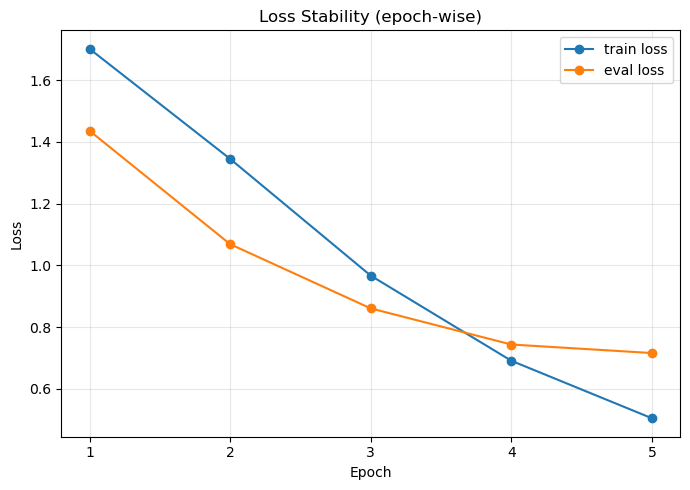

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json, os

# 1) trainer_state.json → df 만들기 (이미 했던 부분)
STATE_PATH = os.path.join(BASE_DIR, "checkpoint-795", "trainer_state.json")
with open(STATE_PATH, "r", encoding="utf-8") as f:
    state = json.load(f)

df = pd.DataFrame(state["log_history"])

# epoch 값 채워넣기
df["epoch"] = df["epoch"].ffill()

# 2) 정수 epoch 범위 정의
max_epoch = int(np.floor(df["epoch"].max()))
epoch_ids = list(range(1, max_epoch + 1))

train_means = []
eval_means = []

for e in epoch_ids:
    # e-1 ~ e 구간의 train loss 평균
    tr_mask = (df["loss"].notna()) & (df["epoch"] > (e-1)) & (df["epoch"] <= e)
    train_means.append(df.loc[tr_mask, "loss"].mean())
    
    # e-1 ~ e 구간의 eval_loss (보통 1개뿐이라 mean해도 됨)
    ev_mask = (df["eval_loss"].notna()) & (df["epoch"] > (e-1)) & (df["epoch"] <= e)
    eval_means.append(df.loc[ev_mask, "eval_loss"].mean())

# 3) 깔끔한 epoch-wise 그래프
plt.figure(figsize=(7,5))
plt.plot(epoch_ids, train_means, marker="o", label="train loss")
plt.plot(epoch_ids, eval_means,  marker="o", label="eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Stability (epoch-wise)")
plt.grid(True, alpha=0.3)
plt.xticks(epoch_ids)
plt.legend()
plt.tight_layout()
plt.show()


# 2. baseline_model_seq_training

## seed = 43

## 0. 공통 설정

In [1]:
import os, re, glob, json, time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_from_disk
from transformers import AutoModel, TrainingArguments, Trainer
from safetensors.torch import load_file
from scipy.stats import spearmanr
import psutil

# ===========================
# 경로 설정 (필요하면 수정)
# ===========================
STAGE2_DIR = "./empathy_roberta_stage2_multitask"  # Stage2 output 디렉토리
DATASET_PATH = "./empathy_dataset/hf_tokenized_roberta-base"  # 토큰화 HF 데이터셋
MODEL_NAME = "roberta-base"
LAMBDA_EMO = 0.3  # 멀티태스크 loss 비율
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


## 1. 가장 최신 checkpoint 찾기

In [2]:
def find_latest_checkpoint(base_dir):
    ckpt_dirs = glob.glob(os.path.join(base_dir, "checkpoint-*"))
    assert ckpt_dirs, f"No checkpoint-* found in {base_dir}"

    def extract_step(path):
        m = re.search(r"checkpoint-(\d+)", path)
        return int(m.group(1)) if m else -1

    latest = max(ckpt_dirs, key=extract_step)
    print("Latest checkpoint:", latest)
    return latest

latest_stage2 = find_latest_checkpoint(STAGE2_DIR)


Latest checkpoint: ./empathy_roberta_stage2_multitask\checkpoint-1590


## 2. 데이터셋 로드

In [3]:
ds = load_from_disk(DATASET_PATH)
for split in ds.keys():
    ds[split].set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels", "emotion_labels"],
    )

num_emotions = int(torch.max(ds["train"]["emotion_labels"]).item() + 1)
print("splits:", ds.keys(), "num_emotions:", num_emotions)


splits: dict_keys(['train', 'validation', 'test']) num_emotions: 32


## 3. Stage2 모델 클래스 정의 + 가중치 로드

In [4]:
class EmpathyBaselineMultiTask(nn.Module):
    def __init__(self, model_name: str, num_emotions: int, lambda_emo: float = 0.3):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden = self.encoder.config.hidden_size

        self.dropout = nn.Dropout(0.1)
        # 공감 회귀 헤드
        self.reg_head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden, 1),
        )
        # 감정 분류 헤드
        self.emo_head = nn.Linear(hidden, num_emotions)

        self.loss_reg = nn.MSELoss()
        self.loss_ce = nn.CrossEntropyLoss()
        self.lambda_emo = lambda_emo

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,
        emotion_labels=None,
    ):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = self.dropout(out.last_hidden_state[:, 0])

        reg_score = self.reg_head(cls).squeeze(-1)  # [B]
        emo_logits = self.emo_head(cls)             # [B, C]

        loss = None
        if (labels is not None) or (emotion_labels is not None):
            loss_reg = self.loss_reg(reg_score, labels) if labels is not None else 0.0
            loss_emo = self.loss_ce(emo_logits, emotion_labels) if emotion_labels is not None else 0.0
            loss = loss_reg + self.lambda_emo * loss_emo

        logits = torch.cat([reg_score.unsqueeze(-1), emo_logits], dim=-1)
        return {"loss": loss, "logits": logits}

# 모델 생성 + checkpoint 로드
model = EmpathyBaselineMultiTask(MODEL_NAME, num_emotions, lambda_emo=LAMBDA_EMO)

state_path = os.path.join(latest_stage2, "model.safetensors")
state_dict = load_file(state_path)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

print("Stage2 model loaded from:", state_path)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Stage2 model loaded from: ./empathy_roberta_stage2_multitask\checkpoint-1590\model.safetensors


## 4. MAE / Spearman / emotion_accuracy 계산

In [5]:
def compute_metrics(eval_pred):
    preds, labels = eval_pred

    if isinstance(preds, tuple):
        preds = preds[0]

    reg_pred = preds[:, 0]
    emo_logits = preds[:, 1:]
    emo_pred = emo_logits.argmax(axis=-1)

    # labels: tuple / dict / tensor 모두 대응
    if isinstance(labels, tuple):
        reg_true, emo_true = labels
    elif isinstance(labels, dict):
        reg_true = labels["labels"]
        emo_true = labels["emotion_labels"]
    else:
        reg_true = labels
        emo_true = None

    reg_true = np.array(reg_true).reshape(-1)
    reg_pred = np.array(reg_pred).reshape(-1)

    mae = float(np.mean(np.abs(reg_pred - reg_true)))
    spearman = float(spearmanr(reg_true, reg_pred).correlation)

    metrics = {"mae": mae, "spearman": spearman}
    if emo_true is not None:
        emo_true = np.array(emo_true).reshape(-1)
        emo_acc = float((emo_pred == emo_true).mean())
        metrics["emotion_accuracy"] = emo_acc
    return metrics

eval_args = TrainingArguments(
    output_dir="./tmp_eval_stage2",
    per_device_eval_batch_size=32,
    do_train=False,
    do_eval=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=ds["test"],   # 필요시 "validation"으로 바꿔도 됨
    compute_metrics=compute_metrics,
)

stage2_metrics = trainer.evaluate()
stage2_metrics


{'eval_loss': 1.4390230178833008,
 'eval_model_preparation_time': 0.0157,
 'eval_mae': 0.52839195728302,
 'eval_spearman': 0.7056313983161202,
 'eval_emotion_accuracy': 0.4020926756352765,
 'eval_runtime': 2.6188,
 'eval_samples_per_second': 255.459,
 'eval_steps_per_second': 8.019}

## 5. 파라미터 수

In [6]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"[Stage2] Total params: {total_params:,}")
print(f"[Stage2] Trainable params: {trainable_params:,}")


[Stage2] Total params: 125,261,601
[Stage2] Trainable params: 125,261,601


## 6. 추론 속도 측정

In [7]:
# test 샘플 하나 뽑아서 batch=1 구성
sample = ds["test"][0]
batch = {
    "input_ids": sample["input_ids"].unsqueeze(0).to(device),
    "attention_mask": sample["attention_mask"].unsqueeze(0).to(device),
}

# warmup
with torch.no_grad():
    for _ in range(5):
        _ = model(**batch)

N = 50
start = time.time()
with torch.no_grad():
    for _ in range(N):
        _ = model(**batch)
end = time.time()

latency_ms = (end - start) / N * 1000
print(f"[Stage2] Avg latency (batch=1): {latency_ms:.2f} ms")


[Stage2] Avg latency (batch=1): 74.18 ms


## 7. GPU / CPU 메모리 사용량

In [8]:
process = psutil.Process(os.getpid())

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

with torch.no_grad():
    _ = model(**batch)

gpu_mem = (
    torch.cuda.max_memory_allocated() / (1024**2)
    if torch.cuda.is_available()
    else 0.0
)
cpu_mem = process.memory_info().rss / (1024**2)

print(f"[Stage2] Peak GPU memory: {gpu_mem:.1f} MB")
print(f"[Stage2] CPU RSS memory: {cpu_mem:.1f} MB")


[Stage2] Peak GPU memory: 495.7 MB
[Stage2] CPU RSS memory: 1463.3 MB


## 8. epoch-wise loss stability 그래프

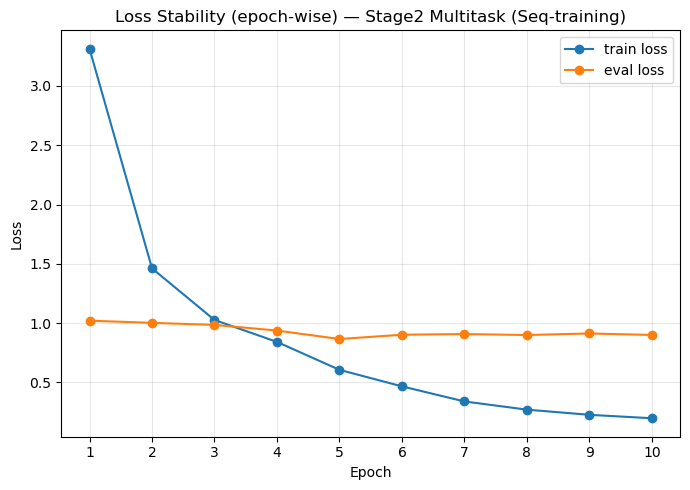

In [9]:
def plot_loss_stability_epochwise(checkpoint_path, title="Stage2 Multitask"):
    state_file = os.path.join(checkpoint_path, "trainer_state.json")
    with open(state_file, "r", encoding="utf-8") as f:
        state = json.load(f)

    df = pd.DataFrame(state["log_history"])
    df["epoch"] = df["epoch"].ffill()

    max_epoch = int(np.floor(df["epoch"].max()))
    epochs = list(range(1, max_epoch + 1))

    train_means, eval_means = [], []
    for e in epochs:
        tr_mask = (df["loss"].notna()) & (df["epoch"] > (e-1)) & (df["epoch"] <= e)
        ev_mask = (df["eval_loss"].notna()) & (df["epoch"] > (e-1)) & (df["epoch"] <= e)
        train_means.append(df.loc[tr_mask, "loss"].mean())
        eval_means.append(df.loc[ev_mask, "eval_loss"].mean())

    plt.figure(figsize=(7,5))
    plt.plot(epochs, train_means, marker="o", label="train loss")
    plt.plot(epochs, eval_means, marker="o", label="eval loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Stability (epoch-wise) — {title}")
    plt.grid(True, alpha=0.3)
    plt.xticks(epochs)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_loss_stability_epochwise(latest_stage2, title="Stage2 Multitask (Seq-training)")


# model_method1

## seed값 39 설정, lambda = 0.05

## 0. 공통 설정

In [1]:
import os
import json
import time
import psutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from datasets import load_from_disk
from transformers import AutoModel, TrainingArguments, Trainer
from safetensors.torch import load_file
from scipy.stats import spearmanr


## 1. MultiViewCascadeModel 정의

In [2]:
class MultiViewCascadeModel(nn.Module):
    def __init__(self, encoder_name, num_emotions, pretrained_encoder_path=None):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(encoder_name)
        hidden = self.encoder.config.hidden_size

        # Stage0 pretrained encoder 로드
        if pretrained_encoder_path is not None:
            print(">> Loading pretrained encoder:", pretrained_encoder_path)
            state = torch.load(pretrained_encoder_path, map_location="cpu")
            self.encoder.load_state_dict(state, strict=False)

        self.emo_head = nn.Linear(hidden, num_emotions)

        self.reg_head = nn.Sequential(
            nn.Linear(hidden + num_emotions, hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden, 1),
        )

        self.loss_reg = nn.SmoothL1Loss()
        self.loss_emo = nn.CrossEntropyLoss()

    def forward(
        self,
        input_ids_ctx=None,
        attention_mask_ctx=None,
        input_ids_full=None,
        attention_mask_full=None,
        labels=None,
        emotion_labels=None,
    ):
        # Emotion (context only)
        out_ctx = self.encoder(
            input_ids=input_ids_ctx,
            attention_mask=attention_mask_ctx,
        )
        cls_ctx = out_ctx.last_hidden_state[:, 0]
        emo_logits = self.emo_head(cls_ctx)

        # Empathy regression (full view)
        out_full = self.encoder(
            input_ids=input_ids_full,
            attention_mask=attention_mask_full,
        )
        cls_full = out_full.last_hidden_state[:, 0]

        feat = torch.cat([cls_full, emo_logits], dim=-1)
        reg_score = self.reg_head(feat).squeeze(-1)

        loss = None
        if labels is not None and emotion_labels is not None:
            loss_r = self.loss_reg(reg_score, labels.float())
            loss_e = self.loss_emo(emo_logits, emotion_labels.long())
            loss = loss_r + 0.3 * loss_e

        logits = torch.cat([reg_score.unsqueeze(-1), emo_logits], dim=-1)

        return {"loss": loss, "logits": logits}

## 2. Dataset 로드 (MultiView tokenized)

In [3]:
DATASET_PATH = "./empathy_dataset/hf_tokenized_multiview"   # ← 네가 실제 저장한 경로로 수정!
ds = load_from_disk(DATASET_PATH)

# torch tensor 포맷 설정
for split in ds.keys():
    ds[split].set_format(
        type="torch",
        columns=[
            "input_ids_ctx", "attention_mask_ctx",
            "input_ids_full", "attention_mask_full",
            "labels", "emotion_labels",
        ],
    )

num_emotions = int(torch.max(ds["train"]["emotion_labels"]).item() + 1)
print("Dataset loaded. num_emotions =", num_emotions)

Dataset loaded. num_emotions = 32


## 3. 최신 체크포인트 자동 검색

In [4]:
OUTPUT_DIR = "./mv_cascade_ed_out"

all_ckpts = [
    os.path.join(OUTPUT_DIR, d)
    for d in os.listdir(OUTPUT_DIR)
    if d.startswith("checkpoint")
]
latest_ckpt = sorted(all_ckpts, key=lambda x: int(x.split("-")[-1]))[-1]
model_safetensor_path = os.path.join(latest_ckpt, "model.safetensors")

print("Using checkpoint:", latest_ckpt)

Using checkpoint: ./mv_cascade_ed_out\checkpoint-2540


## 4. 모델 로드

In [5]:
MODEL_NAME = "roberta-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MultiViewCascadeModel(MODEL_NAME, num_emotions)
state_dict = load_file(model_safetensor_path)
model.load_state_dict(state_dict, strict=False)

model.to(device)
model.eval()

print("Model loaded on:", device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on: cuda


## 5. 평가 지표 계산 (MAE / Spearman / Emotion Accuracy)

In [6]:
def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # preds: [N, 1 + num_emotions]
    if isinstance(preds, tuple):
        preds = preds[0]

    reg_pred = preds[:, 0]
    emo_logits = preds[:, 1:]
    emo_pred = emo_logits.argmax(axis=-1)

    # labels: (labels, emotion_labels) 튜플 or dict or array
    if isinstance(labels, tuple):
        reg_true, emo_true = labels
    elif isinstance(labels, dict):
        reg_true = labels["labels"]
        emo_true = labels["emotion_labels"]
    else:
        # 단일 레이블만 있을 때 (이 케이스는 지금은 거의 없음)
        reg_true = labels
        emo_true = None

    reg_true = np.array(reg_true).reshape(-1)
    reg_pred = np.array(reg_pred).reshape(-1)

    mae = float(np.mean(np.abs(reg_pred - reg_true)))
    spearman = float(spearmanr(reg_true, reg_pred).correlation)

    metrics = {"MAE": mae, "Spearman": spearman}

    if emo_true is not None:
        emo_true = np.array(emo_true).reshape(-1)
        emo_pred = np.array(emo_pred).reshape(-1)
        emo_acc = float((emo_pred == emo_true).mean())
        metrics["Emotion_Accuracy"] = emo_acc

    return metrics



args = TrainingArguments(
    output_dir="./eval_tmp",
    per_device_eval_batch_size=32,
    dataloader_drop_last=False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    eval_dataset=ds["test"],
    compute_metrics=compute_metrics,
)

metrics = trainer.evaluate()
print("\n=== EVALUATION METRICS ===")
print(metrics)


=== EVALUATION METRICS ===
{'eval_loss': 0.9667147397994995, 'eval_model_preparation_time': 0.0, 'eval_MAE': 0.3576429784297943, 'eval_Spearman': 0.7222110759316194, 'eval_Emotion_Accuracy': 0.26905829596412556, 'eval_runtime': 4.6736, 'eval_samples_per_second': 143.145, 'eval_steps_per_second': 4.493}


## 6. 파라미터 수 집계

In [7]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal params     : {total_params:,}")
print(f"Trainable params : {trainable_params:,}")



Total params     : 125,286,177
Trainable params : 125,286,177


## 7. 추론 속도(latency)

In [8]:
sample = ds["test"][0]
batch = {
    "input_ids_ctx": sample["input_ids_ctx"].unsqueeze(0).to(device),
    "attention_mask_ctx": sample["attention_mask_ctx"].unsqueeze(0).to(device),
    "input_ids_full": sample["input_ids_full"].unsqueeze(0).to(device),
    "attention_mask_full": sample["attention_mask_full"].unsqueeze(0).to(device),
}

# warmup
with torch.no_grad():
    for _ in range(5):
        _ = model(**batch)

# 측정
N = 50
start = time.time()
with torch.no_grad():
    for _ in range(N):
        _ = model(**batch)
end = time.time()

latency_ms = (end - start) / N * 1000
print(f"\nAvg inference latency (batch=1): {latency_ms:.2f} ms")


Avg inference latency (batch=1): 97.17 ms


## 8. GPU / CPU 메모리 사용량

In [9]:
process = psutil.Process(os.getpid())

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

with torch.no_grad():
    _ = model(**batch)

gpu_mem = (
    torch.cuda.max_memory_allocated() / (1024**2)
    if torch.cuda.is_available()
    else 0
)
cpu_mem = process.memory_info().rss / (1024**2)

print(f"\nPeak GPU memory : {gpu_mem:.1f} MB")
print(f"CPU memory RSS  : {cpu_mem:.1f} MB")



Peak GPU memory : 496.6 MB
CPU memory RSS  : 1469.3 MB


## 9. Loss stability(epoch-wise) 그래프

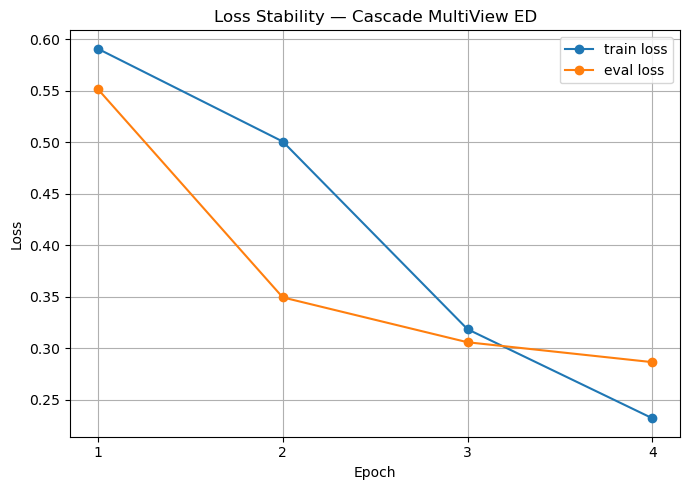

In [10]:
def plot_loss_stability_epochwise(ckpt_dir, title="Cascade Model"):
    state_path = os.path.join(ckpt_dir, "trainer_state.json")
    with open(state_path, "r", encoding="utf-8") as f:
        state = json.load(f)

    df = pd.DataFrame(state["log_history"])

    if "epoch" not in df.columns:
        print("No 'epoch' in log_history")
        return

    df["epoch"] = df["epoch"].ffill()
    max_epoch = int(np.floor(df["epoch"].max()))
    epochs = list(range(1, max_epoch + 1))

    train_means, eval_means = [], []
    for e in epochs:
        tr = df[(df["epoch"] > e - 1) & (df["epoch"] <= e) & (df["loss"].notna())]
        ev = df[(df["epoch"] > e - 1) & (df["epoch"] <= e) & (df["eval_loss"].notna())]

        train_means.append(tr["loss"].mean())
        eval_means.append(ev["eval_loss"].mean())

    plt.figure(figsize=(7, 5))
    plt.plot(epochs, train_means, marker="o", label="train loss")
    plt.plot(epochs, eval_means, marker="o", label="eval loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Stability — {title}")
    plt.grid(True)
    plt.xticks(epochs)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_loss_stability_epochwise(latest_ckpt, title="Cascade MultiView ED")